In [1]:
#PACKAGE IMPORTS

from typing import Tuple, Dict, Any, List
import os
from tkinter import Tk, filedialog, simpledialog, messagebox, Button, Label
import tkinter as tk
from tkinter.filedialog import askopenfilenames, askdirectory, asksaveasfilename, askopenfilename
from tkinter.simpledialog import askinteger

import geopandas as gpd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
import pandas as pd
import panel as pn
from rasterio.enums import Resampling
from rasterio.transform import from_bounds
from rasterio.features import rasterize
import rasterio
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
import xarray as xr
import seaborn as sns

from IPython.display import display

from joblib import Parallel, delayed

from scipy.ndimage import distance_transform_edt
from shapely.geometry import LineString



In [23]:
#UNIFIED FILE IMPORTS

def select_files(title, filetypes, multiple=True):
    root = Tk()
    root.withdraw()
    root.attributes("-topmost", True)
    if multiple:
        file_paths = filedialog.askopenfilenames(title=title, filetypes=filetypes)
    else:
        file_paths = filedialog.askopenfilename(title=title, filetypes=filetypes)
    root.destroy()
    return list(file_paths) if multiple else file_paths

# Select all required files in one popup
def select_all_files():
    mask_file = select_files("Select a Mask GeoJSON File", [("GeoJSON files", "*.geojson"), ("All files", "*.*")], multiple=False)
    geojson_files = select_files("Select GeoJSON Files", [("GeoJSON files", "*.geojson"), ("All files", "*.*")])
    line_geojson_files = select_files("Select GeoJSON Line Files", [("GeoJSON files", "*.geojson"), ("All files", "*.*")])
    target_files = select_files("Select Target GeoJSON Files", [("GeoJSON files", "*.geojson"), ("All files", "*.*")])
    raster_files = select_files("Select Raster Files", [("GeoTIFF files", "*.tif"), ("All files", "*.*")])
    return mask_file, geojson_files, line_geojson_files, target_files, raster_files

# Use the function to select all files
mask_file, geojson_files, line_geojson_files, target_files, raster_files = select_all_files()

print(f"Selected Mask file: {mask_file}")
print(f"Selected GeoJSON files: {geojson_files}")
print(f"Selected Line GeoJSON files: {line_geojson_files}")
print(f"Selected Target files: {target_files}")
print(f"Selected Raster files: {raster_files}")

# Select columns from vector files
vector_features_to_process = []

def select_columns(geojson_file):
    """Display column selection widgets for a given GeoJSON file."""
    gdf = gpd.read_file(geojson_file)
    columns = gdf.columns.tolist()
    selection = widgets.SelectMultiple(
        options=columns,
        description=f'Select columns for {os.path.basename(geojson_file)}:',
        rows=10
    )
    display(selection)

    def on_button_click(b):
        selected_columns = [(geojson_file, col) for col in selection.value]
        vector_features_to_process.extend(selected_columns)
        print(f'Selected columns from {geojson_file}: {selected_columns}')

    button = widgets.Button(description="Submit Selection")
    button.on_click(on_button_click)
    display(button)

for file in geojson_files:
    select_columns(file)

Selected Mask file: C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/pilot_map_testing_mask.geojson
Selected GeoJSON files: ['C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/map1_geology.geojson', 'C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/map3_geology.geojson']
Selected Line GeoJSON files: []
Selected Target files: []
Selected Raster files: []


SelectMultiple(description='Select columns for map1_geology.geojson:', options=('lithology', 'age', 'lithology…

Button(description='Submit Selection', style=ButtonStyle())

SelectMultiple(description='Select columns for map3_geology.geojson:', options=('lithology', 'age', 'lithology…

Button(description='Submit Selection', style=ButtonStyle())

Selected columns from C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/map1_geology.geojson: [('C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/map1_geology.geojson', 'lithology')]
Selected columns from C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/map3_geology.geojson: [('C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/map3_geology.geojson', 'lithology')]


In [ ]:
#CALCULATE GRID SIZE (from mask short edge)

# Function to compute grid size based on the mask file
def compute_grid_size(geojson_file: str, short_edge_cells: int = 20) -> Tuple[int, int]:
    # Read the GeoJSON file using GeoPandas
    gdf = gpd.read_file(geojson_file)
    
    # Get the bounding box of the masking region
    minx, miny, maxx, maxy = gdf.total_bounds
    
    # Calculate width and height of the bounding box
    width = maxx - minx
    height = maxy - miny

    # Determine which is the short and long edge
    if width < height:
        short_edge = width
        long_edge = height
        orientation = 'portrait'
    else:
        short_edge = height
        long_edge = width
        orientation = 'landscape'

    # Compute the aspect ratio
    aspect_ratio = long_edge / short_edge

    # Compute the number of cells for the long edge
    long_edge_cells = int(short_edge_cells * aspect_ratio)

    # Determine the grid size based on the orientation
    if orientation == 'portrait':
        grid_size = (short_edge_cells, long_edge_cells)
    else:
        grid_size = (long_edge_cells, short_edge_cells)

    return grid_size

# Prompt the user for the short_edge_cells value using tkinter
root = Tk()
root.withdraw()  # Hide the root window
root.attributes("-topmost", True)  # Ensure it is on top


# Ask the user for the short edge size
short_edge_cells = simpledialog.askinteger("Input", "Enter the number of cells for the short edge:", minvalue=1)

root.destroy()  # Close the tkinter root window

if short_edge_cells is None:
    raise ValueError("You must enter a valid number for the short edge size.")



# Compute grid size using the mask file
grid_size = compute_grid_size(mask_file, short_edge_cells=short_edge_cells)[::-1]
print(f"Calculated grid size: {grid_size}")


In [24]:
# UNIFIED PROCESSING FUNCTION WITH COMMON GRID ALIGNMENT
def process_file(file, file_type, grid_size, mask_file=None, vector_features_to_process=None, buffer_lines=None, buffer_distance_meters=None):
    # Define grid bounds based on the mask file
    mask_gdf = gpd.read_file(mask_file)
    mask_gdf = mask_gdf.to_crs("EPSG:3857")  # Ensure a projected CRS for mask
    minx, miny, maxx, maxy = mask_gdf.total_bounds

    # Debug step to check the bounds
    #print(f"Grid bounds - minx: {minx}, miny: {miny}, maxx: {maxx}, maxy: {maxy}")

    # Define the transform for the entire grid area based on the mask bounds
    common_transform = from_bounds(minx, miny, maxx, maxy, grid_size[1], grid_size[0])

    # Debug step to verify function inputs
    #print(f"Buffer lines: {buffer_lines}, Buffer distance meters: {buffer_distance_meters}")

    if file_type == 'target':
        # Buffer and rasterize targets
        target_buffer_size = get_buffer_size()
        target_df = gpd.read_file(file)
        target_df_projected = target_df.to_crs("EPSG:3857")
        target_df_projected['geometry'] = target_df_projected.geometry.buffer(target_buffer_size)
        target_geometry_generator = ((geom, 1) for geom in target_df_projected.geometry)
        target_data = rasterize(shapes=target_geometry_generator, out_shape=grid_size, fill=0, transform=common_transform).astype('float32')
        target_data_3D = np.expand_dims(target_data, axis=0)
        target_layer_name = f"TARGET_{os.path.basename(file).replace('.geojson', '')}"
        return target_data_3D, target_layer_name

    elif file_type == 'vector':
        # Process vector data to create numpy grid
        gdf = gpd.read_file(file)
        gdf = gdf.to_crs("EPSG:3857")
        feature_columns = [col for _, col in vector_features_to_process if _ == file]
        vector_layers = []
        vector_layer_names = []
        for feature_column in feature_columns:
            unique_categories = gdf[feature_column].unique()
            category_to_int = {cat: i for i, cat in enumerate(unique_categories)}
            sindex = gdf.sindex
            x = np.linspace(minx, maxx, grid_size[1] + 1)
            y = np.linspace(miny, maxy, grid_size[0] + 1)
            cells = [box(x[j], y[i], x[j + 1], y[i + 1]) for i in range(grid_size[0]) for j in range(grid_size[1])]
            results = Parallel(n_jobs=-1)(delayed(process_cell)(idx, cell, gdf, sindex, feature_column, category_to_int, grid_size) for idx, cell in enumerate(cells))
            grid = np.full(grid_size, np.nan)
            for i, j, value in results:
                grid[i, j] = value
            grid_flipped = np.flipud(grid)
            vector_layers.append(np.expand_dims(grid_flipped, axis=0))
            vector_layer_names.append(f"{os.path.basename(file).replace('.geojson', '')}_{feature_column}")
        return np.concatenate(vector_layers, axis=0), vector_layer_names

    elif file_type == 'line':
        # Process line vector files with buffering and distance calculation
        buffer_lines = user_buffer_choice()
        buffer_distance_meters = get_buffer_distance_meters() if buffer_lines else 0
        gdf = gpd.read_file(file)

        # Reproject to a projected CRS if necessary (e.g., UTM)
        if not gdf.crs or not gdf.crs.is_projected:
            print("Reprojecting to a UTM CRS for accurate distance buffering...")
            gdf = gdf.to_crs(gdf.estimate_utm_crs())

        # Calculate pixel distance if buffering is enabled
        pixel_distance = 0
        if buffer_lines:
            pixel_distance = calculate_pixel_distance(gdf, grid_size, buffer_distance_meters)
            print(f"Buffer distance in pixels: {pixel_distance}")

        shapes = []

        # Iterate through each geometry, ensuring it is not None
        for geom in gdf.geometry:
            if geom is None:
                continue  # Skip None geometries
            if geom.geom_type == 'LineString':
                shapes.append((geom, 1))
            elif geom.geom_type == 'MultiLineString':
                for line in geom.geoms:
                    if isinstance(line, LineString):
                        shapes.append((line, 1))

        # Rasterize the geometries to create the binary grid
        if shapes:
            binary_grid = rasterize(shapes, out_shape=grid_size, transform=common_transform, fill=0, dtype='uint8')

            if buffer_lines and pixel_distance > 0:
                raster_map = calculate_distance(binary_grid, max_distance=pixel_distance)
            else:
                raster_map = binary_grid.astype(np.float32)
        else:
            print(f"No valid line geometries found in {file}. Skipping...")
            raster_map = np.zeros(grid_size, dtype=np.float32)

        line_layer_name = f"LINE_{os.path.basename(file).replace('.geojson', '')}"
        return np.expand_dims(raster_map, axis=0), line_layer_name
    
    elif file_type == 'raster':
        # Process raster files
        if not mask_file:
            print("No mask file provided. Skipping raster processing.")
            return None, None
        mask_gdf = gpd.read_file(mask_file)
        minx, miny, maxx, maxy = mask_gdf.total_bounds
        raster_target_transform = from_bounds(minx, miny, maxx, maxy, grid_size[1], grid_size[0])
        raster_target_crs = "EPSG:4326"
        with rasterio.open(file, 'r') as src:
            print(f"Processing file: {file}")
            src_crs = src.crs if src.crs != raster_target_crs else raster_target_crs
            raster_data_array = np.full(grid_size, np.nan, dtype=np.float32)
            nodata_value = src.nodata if src.nodata is not None else np.nan
            reproject(
                source=rasterio.band(src, 1),
                destination=raster_data_array,
                src_transform=src.transform,
                src_crs=src_crs,
                dst_transform=common_transform,
                dst_crs=raster_target_crs,
                resampling=Resampling.nearest,
                src_nodata=nodata_value,
                dst_nodata=np.nan
            )
        raster_name = os.path.basename(file).replace('.tiff', '').replace('.tif', '')
        return np.expand_dims(raster_data_array, axis=0), raster_name

    else:
        raise ValueError("Unsupported file type provided.")

# Helper functions
def get_buffer_size():
    root = Tk()
    root.withdraw()
    root.attributes("-topmost", True)
    buffer_size = simpledialog.askinteger("Input", "Enter the target buffer size in meters:", minvalue=1)
    root.destroy()
    return buffer_size

def process_cell(idx, cell, gdf, sindex, feature_column, category_to_int, grid_size):
    i, j = divmod(idx, grid_size[1])
    possible_matches_index = list(sindex.intersection(cell.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    intersections = possible_matches.geometry.intersection(cell)
    valid_intersections = intersections[intersections.area > 0]
    if valid_intersections.empty:
        return i, j, np.nan
    largest_intersection_idx = valid_intersections.area.idxmax()
    category = possible_matches.loc[largest_intersection_idx, feature_column]
    return i, j, category_to_int[category]

def calculate_distance(arr, max_distance=20, dtype=np.float32):
    arr = np.asarray(arr, dtype=bool)
    dist = distance_transform_edt(~arr)
    normalized_dist = np.clip(1 - dist / max_distance, 0, 1)
    return normalized_dist.astype(dtype)

# Function to calculate pixel distance from buffer distance in meters
def calculate_pixel_distance(gdf, grid_size, buffer_distance_meters):
    height, width = grid_size
    bounds = gdf.total_bounds
    x_range_meters = bounds[2] - bounds[0]
    y_range_meters = bounds[3] - bounds[1]
    x_res = x_range_meters / width
    y_res = y_range_meters / height
    pixel_distance = buffer_distance_meters / ((x_res + y_res) / 2)
    return int(pixel_distance)

# Function for user to choose between buffering or rasterizing
def user_buffer_choice():
    choice = {"buffer": None}

    def set_choice_buffer():
        choice["buffer"] = True
        window.destroy()

    def set_choice_rasterize():
        choice["buffer"] = False
        window.destroy()

    window = Tk()
    window.title("Choose Processing Option")
    label = Label(window, text="Would you like to buffer the lines (calculate distances) or just rasterize them?")
    label.pack(pady=10)
    buffer_button = Button(window, text="Buffer (Calculate Distance)", command=set_choice_buffer)
    buffer_button.pack(side="left", padx=20, pady=20)
    rasterize_button = Button(window, text="Rasterize Only", command=set_choice_rasterize)
    rasterize_button.pack(side="right", padx=20, pady=20)
    window.mainloop()
    return choice["buffer"]

def get_buffer_distance_meters():
    root = Tk()
    root.withdraw()
    try:
        buffer_distance = simpledialog.askfloat("Input Buffer Distance", "Please enter buffer distance in meters:")
    except ValueError:
        messagebox.showerror("Invalid Input", "Please enter a valid number.")
        buffer_distance = None
    root.destroy()
    return buffer_distance

# Ask user once for buffer choice
buffer_lines = user_buffer_choice()
buffer_distance_meters = get_buffer_distance_meters() if buffer_lines else 0

# Process targets
target_data = []
target_layer_names = []
if target_files:
    for file in target_files:
        target_layer, target_layer_name = process_file(file, 'target', grid_size, mask_file=mask_file)
        target_data.append(target_layer)
        target_layer_names.append(target_layer_name)
    target_data = np.concatenate(target_data, axis=0)
    print(f"Target data shape: {target_data.shape}")
else:
    print("No target files detected.")
    target_data = np.array([])
    target_layer_names = []

# Process rasters
raster_data = []
raster_names = []
if raster_files:
    if not mask_file:
        print("No mask file selected. Skipping raster processing.")
    else:
        for file in raster_files:
            raster_layer, raster_name = process_file(file, 'raster', grid_size, mask_file=mask_file)
            if raster_layer is not None:
                raster_data.append(raster_layer)
                raster_names.append(raster_name)
        if raster_data:
            raster_data = np.concatenate(raster_data, axis=0)
            print(f"Raster data shape: {raster_data.shape}")
        else:
            print("No raster data processed.")
else:
    print("No raster files detected.")
    raster_data = np.array([])
    raster_names = []

# Process line vectors
line_vector_data = []
line_layer_names = []
if line_geojson_files:
    for file in line_geojson_files:
        line_layer, line_layer_name = process_file(file, 'line', grid_size, mask_file=mask_file, buffer_lines=buffer_lines, buffer_distance_meters=buffer_distance_meters)
        line_vector_data.append(line_layer)
        line_layer_names.append(line_layer_name)
    line_vector_data = np.concatenate(line_vector_data, axis=0)
    print(f"Line vector data shape: {line_vector_data.shape}")
else:
    print("No line vector files selected.")
    line_vector_data = np.array([])
    line_layer_names = []

# Process polygon vectors
vector_data = []
vector_feature_grids = {}
vector_layer_names = []
if geojson_files and vector_features_to_process:
    for file in geojson_files:
        vector_layer, feature_names = process_file(file, 'vector', grid_size, mask_file=mask_file, vector_features_to_process=vector_features_to_process)
        vector_data.append(vector_layer)
        vector_layer_names.extend(feature_names)
        for feature_name, layer in zip(feature_names, vector_layer):
            vector_feature_grids[feature_name] = layer
    vector_data = np.concatenate(vector_data, axis=0)
    print(f"Vector data shape: {vector_data.shape}")
else:
    print("No polygon vector files or features selected.")
    vector_data = np.array([])
    vector_feature_grids = {}
    vector_layer_names = []

print(f"vector_data shape: {vector_data.shape}")
print(f"line_vector_data shape: {line_vector_data.shape}")
print(f"raster_data shape: {raster_data.shape}")
print(f"target_data shape: {target_data.shape}")

combined_data = []
combined_layer_names = []

# Create a list to hold non-empty data arrays and their corresponding layer names
data_arrays = []
layer_names = []

# Function to add non-empty data arrays and their names
def add_data_and_names(data_array, names):
    if data_array.size != 0:
        data_arrays.append(data_array)
        layer_names.extend(names)
    else:
        print(f"Skipping empty data array with names: {names}")

# Add vector data
if vector_data.size != 0:
    add_data_and_names(vector_data, vector_layer_names)
else:
    print("Vector data is empty.")

# Add raster data
if raster_data.size != 0:
    add_data_and_names(raster_data, raster_names)
else:
    print("Raster data is empty.")

# Add line vector data
if line_vector_data.size != 0:
    add_data_and_names(line_vector_data, line_layer_names)
else:
    print("Line vector data is empty.")

# Add target data
if target_data.size != 0:
    add_data_and_names(target_data, target_layer_names)
else:
    print("Target data is empty.")

# Check if we have at least one non-empty data array
if data_arrays:
    # Check that all arrays have the same x and y dimensions
    first_shape = data_arrays[0].shape[1:]  # Skip the first dimension (number of layers)
    shapes_match = all(data_array.shape[1:] == first_shape for data_array in data_arrays)

    if shapes_match:
        # Concatenate all data arrays along axis=0
        combined_data = np.concatenate(data_arrays, axis=0)
        combined_layer_names = layer_names

        print(f"Combined array shape (with targets): {combined_data.shape}")

        # Check the mapping to ensure it is correct
        print("Layer Name Mapping List:", combined_layer_names)

        # Ensure the combined_data layers match the number of names
        if len(combined_layer_names) == combined_data.shape[0]:
            print(f"Layer name mapping successful. Total layers: {len(combined_layer_names)}")
        else:
            print(f"Warning: Mismatch in layers. {len(combined_layer_names)} names for {combined_data.shape[0]} layers.")
    else:
        print("Error: The x/y dimensions of the arrays do not match.")
        print("Array shapes:")
        for idx, data_array in enumerate(data_arrays):
            print(f"Array {idx} shape: {data_array.shape}")
else:
    print("No data arrays to combine.")

No target files detected.
No raster files detected.
No line vector files selected.
Vector data shape: (2, 50, 94)
vector_data shape: (2, 50, 94)
line_vector_data shape: (0,)
raster_data shape: (0,)
target_data shape: (0,)
Raster data is empty.
Line vector data is empty.
Target data is empty.
Combined array shape (with targets): (2, 50, 94)
Layer Name Mapping List: ['map1_geology_lithology', 'map3_geology_lithology']
Layer name mapping successful. Total layers: 2


In [22]:
# EXPORT DATA ////////// SAVE RASTER & VECTOR DATA

# Hide the root window for file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a folder to save the files
output_directory = askdirectory(
    initialdir=r"C:\Users\TyHow\Documents\3. Work\ML_test_area\exports",
    title="Select a Folder to Save Output Files (BEWARE OVERWRITE!)"
)

if output_directory:
    # Construct file paths using the selected folder and default file names
    output_6_rasters_file = os.path.join(output_directory, "output_rasters.npy")
    output_6_rasters_layer_mappings_file = os.path.join(output_directory, "output_rasters_layer_mappings.npy")

    # Save the files
    np.save(output_6_rasters_file, raster_data)
    np.save(output_6_rasters_layer_mappings_file, raster_feature_mappings)

    print(f"Files saved in: {output_directory}")

# Destroy the root window after file dialogs are closed
root.destroy()

# Hide the root window for file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a folder to save the files
output_directory = askdirectory(
    initialdir=r"C:\Users\TyHow\Documents\3. Work\ML_test_area\exports",
    title="Select a Folder to Save Output Files (BEWARE OVERWRITE!)"
)

if output_directory:
    # Construct file paths using the selected folder and default file names
    output_array_file = os.path.join(output_directory, "output_vectors.npy")
    output_feature_grid_file = os.path.join(output_directory, "output_vector_feature_grid.npy")
    output_feature_mappings_file = os.path.join(output_directory, "output_vector_feature_mappings.npy")
    output_geospatial_info_file = os.path.join(output_directory, "output_vector_geospatial_info.npy")

    # Save the files
    np.save(output_array_file, vector_data)
    np.save(output_feature_grid_file, vector_feature_grids)
    np.save(output_feature_mappings_file, all_feature_mappings)
    np.save(output_geospatial_info_file, vector_geospatial_info_list)

    print(f"Files saved in: {output_directory}")

# Destroy the root window after file dialogs are closed
root.destroy()


In [ ]:
# IMPORT PREEXISTING DATA ////////// IMPORT NETCDF AS ARRAY

# Function to prompt the user to select a .nc file
def select_nc_file():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front

    # Open a file selection dialog
    file_path = filedialog.askopenfilename(
        title="Select NetCDF File",
        filetypes=[("NetCDF files", "*.nc"), ("All files", "*.*")]
    )

    root.destroy()  # Close the root window after file selection
    
    return file_path

# Function to convert a NetCDF file to a NumPy array and extract layer names
def nc_to_numpy_and_layers(file_path):
    try:
        # Load the NetCDF file using xarray
        ds = xr.open_dataset(file_path)
        
        # Display available variables
        print("Variables available in the NetCDF file:")
        for var in ds.data_vars:
            print(var)
        
        # Select the variable to convert to NumPy array (adjust as needed)
        var_name = input("Enter the variable name to convert to NumPy array: ")

        if var_name in ds:
            # Extract the variable and convert it to a NumPy array
            data_array = ds[var_name].values
            print(f"Successfully converted {var_name} to a NumPy array with shape {data_array.shape}")
            
            # Extract layer names (if the variable is multi-dimensional)
            if 'layer' in ds[var_name].dims:
                combined_layer_names = ds[var_name].coords['layer'].values.tolist()
            else:
                # If no specific layer dimension, use the variable name
                combined_layer_names = [var_name]
            
            print(f"Layer names: {combined_layer_names}")
            return data_array, combined_layer_names
        else:
            print(f"Variable '{var_name}' not found in the NetCDF file.")
            return None, None

    except Exception as e:
        print(f"Error loading NetCDF file: {e}")
        return None, None

# Step 1: Select the NetCDF file
selected_file = select_nc_file()

if selected_file:
    print(f"Selected file: {selected_file}")
    
    # Step 2: Convert the selected NetCDF file to a NumPy array and extract layer names
    nc_array, nc_names = nc_to_numpy_and_layers(selected_file)
    
    if nc_array is not None:
        print(f"Converted NumPy array shape: {nc_array.shape}")
        print(f"Combined Layer Names: {nc_names}")
else:
    print("No file selected.")

combined_data = nc_array
combined_layer_names = nc_names


In [27]:
#PLOT COMBINED - with layer names

data_to_plot = combined_data

# Initialize the Panel extension
pn.extension()

# Assuming combined_layer_names is a list that stores the names of each layer
# combined_layer_names should be the list that maps to each layer of the combined_data array

# Function to plot a specific layer using Matplotlib
def plot_layer_bokeh(layer_index):
    # Create the plot
    fig = Figure(figsize=(4, 3))
    ax = fig.add_subplot(111)
    ax.imshow(data_to_plot[layer_index], cmap='viridis', interpolation='nearest', aspect='auto')
    
    # Use combined_layer_names for the title
    ax.set_title(f"Layer {layer_index + 1}: {combined_layer_names[layer_index]}")
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    return pn.pane.Matplotlib(fig, tight=True)

# Create a Bokeh slider widget for selecting the layer
layer_slider = pn.widgets.IntSlider(name='Layer Index', start=0, end=data_to_plot.shape[0] - 1, step=1, value=0)

# Bind the plotting function to the slider value
panel = pn.bind(plot_layer_bokeh, layer_index=layer_slider)

# Display the Panel with the slider and plot
pn.Column(layer_slider, panel).servable()


BokehModel(combine_events=True, render_bundle={'docs_json': {'06d7b210-49b0-451b-9144-13b7b52d9d66': {'version…

Text(0, 0.5, 'Y Coordinate')

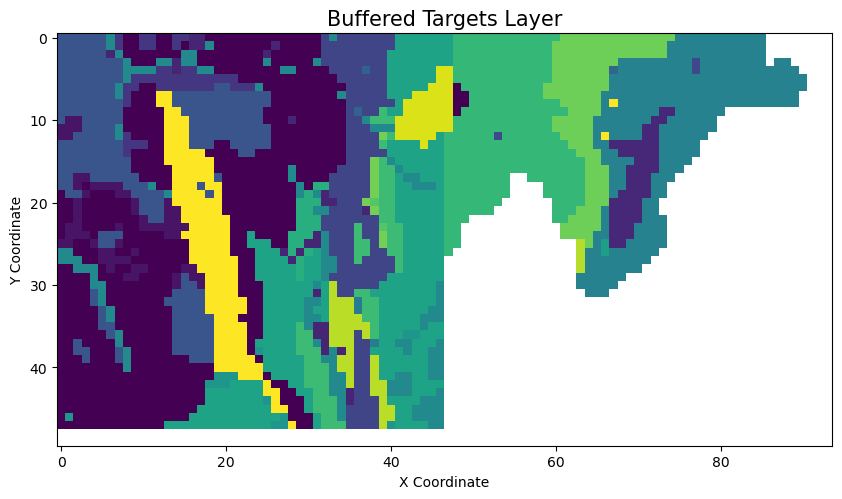

In [26]:
#CREATE SIMPLE PLOT TO EXPORT
plt.figure(figsize=(10,14))
plt.imshow(combined_data[0])
plt.imshow(combined_data[1])
plt.title("Buffered Targets Layer", fontsize=15)
plt.xlabel("X Coordinate", fontsize=10)
plt.ylabel("Y Coordinate", fontsize=10)

In [15]:
# CONVERT TO XARRAY

# Create dummy arrays for X, Y coordinates (you can replace these with your actual coordinates)
x_coords = np.arange(combined_data.shape[2])  # X-coordinates (along the third axis)
y_coords = np.arange(combined_data.shape[1])  # Y-coordinates (along the second axis)
layer_names = combined_layer_names  # Layer names

# Create an xarray DataArray from the combined NumPy array
data_xr = xr.DataArray(
    combined_data, 
    dims=["layer", "y", "x"], 
    coords={"layer": layer_names, "y": y_coords, "x": x_coords},
    name="combined_layers"
)


In [ ]:
# EXPORT DATA ////////// EXPORT XARRAY TO NETCDF

# Hide the root window for the file dialog
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the file dialog to the front

# Prompt the user to select a location to save the NetCDF file
output_file = asksaveasfilename(
    initialfile="THE_CUBE.nc",  # Default file name
    defaultextension=".nc",  # Default extension
    filetypes=[("NetCDF files", "*.nc"), ("All files", "*.*")],
    title="Save NetCDF file"
)

# If the user provides a location, save the NetCDF file
if output_file:
    data_xr.to_netcdf(output_file)
    print(f"Data successfully exported to {output_file}")

# Destroy the root window after file dialog is closed
root.destroy()

# INDIVIDUAL FUNCTIONS FOR TESTING

In [ ]:
#UNIFIED PROCESSING FUNCTION
def process_file(file, file_type, grid_size, mask_file=None, vector_features_to_process=None):
    if file_type == 'target':
        # Buffer and rasterize targets
        target_buffer_size = get_buffer_size()
        target_df = gpd.read_file(file)
        target_df_projected = target_df.to_crs("EPSG:3857")
        target_df_projected['geometry'] = target_df_projected.geometry.buffer(target_buffer_size)
        bounds = target_df_projected.total_bounds
        target_transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], grid_size[1], grid_size[0])
        target_geometry_generator = ((geom, 1) for geom in target_df_projected.geometry)
        target_data = rasterize(shapes=target_geometry_generator, out_shape=grid_size, fill=0, transform=target_transform).astype('float32')
        target_data_3D = np.expand_dims(target_data, axis=0)
        target_layer_name = f"TARGET_{os.path.basename(file).replace('.geojson', '')}"
        return target_data_3D, target_layer_name

    elif file_type == 'vector':
        # Process vector data to create numpy grid
        gdf = gpd.read_file(file)
        gdf = gdf.to_crs("EPSG:3857")
        feature_columns = [col for _, col in vector_features_to_process if _ == file]
        vector_layers = []
        vector_layer_names = []
        for feature_column in feature_columns:
            unique_categories = gdf[feature_column].unique()
            category_to_int = {cat: i for i, cat in enumerate(unique_categories)}
            sindex = gdf.sindex
            x = np.linspace(gdf.total_bounds[0], gdf.total_bounds[2], grid_size[1] + 1)
            y = np.linspace(gdf.total_bounds[1], gdf.total_bounds[3], grid_size[0] + 1)
            cells = [box(x[j], y[i], x[j + 1], y[i + 1]) for i in range(grid_size[0]) for j in range(grid_size[1])]
            results = Parallel(n_jobs=-1)(delayed(process_cell)(idx, cell, gdf, sindex, feature_column, category_to_int, grid_size) for idx, cell in enumerate(cells))
            grid = np.full(grid_size, np.nan)
            for i, j, value in results:
                grid[i, j] = value
            grid_flipped = np.flipud(grid)
            vector_layers.append(np.expand_dims(grid_flipped, axis=0))
            vector_layer_names.append(f"{os.path.basename(file).replace('.geojson', '')}_{feature_column}")
        return np.concatenate(vector_layers, axis=0), vector_layer_names

    elif file_type == 'line':
        # Process line vector files with buffering and distance calculation
        buffer_lines = user_buffer_choice()
        buffer_distance_meters = get_buffer_distance_meters() if buffer_lines else 0
        gdf = gpd.read_file(file)

        # Reproject to a projected CRS if necessary (e.g., UTM)
        if not gdf.crs or not gdf.crs.is_projected:
            print("Reprojecting to a UTM CRS for accurate distance buffering...")
            gdf = gdf.to_crs(gdf.estimate_utm_crs())

        # Calculate pixel distance if buffering is enabled
        pixel_distance = 0
        if buffer_lines:
            pixel_distance = calculate_pixel_distance(gdf, grid_size, buffer_distance_meters)
            print(f"Buffer distance in pixels: {pixel_distance}")

        # Create a binary grid of the line geometries
        transform = rasterio.transform.from_bounds(*gdf.total_bounds, grid_size[1], grid_size[0])
        shapes = []

        # Iterate through each geometry, ensuring it is not None
        for geom in gdf.geometry:
            if geom is None:
                continue  # Skip None geometries
            if geom.geom_type == 'LineString':
                shapes.append((geom, 1))
            elif geom.geom_type == 'MultiLineString':
                for line in geom.geoms:
                    if isinstance(line, LineString):
                        shapes.append((line, 1))

        # Rasterize the geometries to create the binary grid
        if shapes:
            binary_grid = rasterize(shapes, out_shape=grid_size, transform=transform, fill=0, dtype='uint8')

            if buffer_lines and pixel_distance > 0:
                raster_map = calculate_distance(binary_grid, max_distance=pixel_distance)
            else:
                raster_map = binary_grid.astype(np.float32)
        else:
            print(f"No valid line geometries found in {file}. Skipping...")
            raster_map = np.zeros(grid_size, dtype=np.float32)

        line_layer_name = f"LINE_{os.path.basename(file).replace('.geojson', '')}"
        return np.expand_dims(raster_map, axis=0), line_layer_name

    elif file_type == 'raster':
        # Process raster files
        if not mask_file:
            print("No mask file provided. Skipping raster processing.")
            return None, None
        mask_gdf = gpd.read_file(mask_file)
        minx, miny, maxx, maxy = mask_gdf.total_bounds
        mask_gdf = mask_gdf.to_crs("EPSG:4326")
        minx, miny, maxx, maxy = mask_gdf.total_bounds
        raster_target_transform = from_bounds(minx, miny, maxx, maxy, grid_size[1], grid_size[0])
        raster_target_crs = "EPSG:4326"
        with rasterio.open(file, 'r') as src:
            print(f"Processing file: {file}")
            src_crs = src.crs if src.crs != raster_target_crs else raster_target_crs
            raster_data_array = np.full(grid_size, np.nan, dtype=np.float32)
            nodata_value = src.nodata if src.nodata is not None else np.nan
            reproject(
                source=rasterio.band(src, 1),
                destination=raster_data_array,
                src_transform=src.transform,
                src_crs=src_crs,
                dst_transform=raster_target_transform,
                dst_crs=raster_target_crs,
                resampling=Resampling.nearest,
                src_nodata=nodata_value,
                dst_nodata=np.nan
            )
        raster_name = os.path.basename(file).replace('.tiff', '').replace('.tif', '')
        return np.expand_dims(raster_data_array, axis=0), raster_name

    else:
        raise ValueError("Unsupported file type provided.")

# Helper functions

def get_buffer_size():
    root = Tk()
    root.withdraw()
    root.attributes("-topmost", True)
    buffer_size = simpledialog.askinteger("Input", "Enter the target buffer size in meters:", minvalue=1)
    root.destroy()
    return buffer_size

def process_cell(idx, cell, gdf, sindex, feature_column, category_to_int, grid_size):
    i, j = divmod(idx, grid_size[1])
    possible_matches_index = list(sindex.intersection(cell.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    intersections = possible_matches.geometry.intersection(cell)
    valid_intersections = intersections[intersections.area > 0]
    if valid_intersections.empty:
        return i, j, np.nan
    largest_intersection_idx = valid_intersections.area.idxmax()
    category = possible_matches.loc[largest_intersection_idx, feature_column]
    return i, j, category_to_int[category]

# Function to calculate normalized distance
def calculate_distance(arr, max_distance=20, dtype=np.float32):
    arr = np.asarray(arr, dtype=bool)
    dist = distance_transform_edt(~arr)
    normalized_dist = np.clip(1 - dist / max_distance, 0, 1)
    return normalized_dist.astype(dtype)

# Function to calculate pixel distance from buffer distance in meters
def calculate_pixel_distance(gdf, grid_size, buffer_distance_meters):
    height, width = grid_size
    bounds = gdf.total_bounds
    x_range_meters = bounds[2] - bounds[0]
    y_range_meters = bounds[3] - bounds[1]
    x_res = x_range_meters / width
    y_res = y_range_meters / height
    pixel_distance = buffer_distance_meters / ((x_res + y_res) / 2)
    return int(pixel_distance)

# Function for user to choose between buffering or rasterizing
def user_buffer_choice():
    choice = {"buffer": None}

    def set_choice_buffer():
        choice["buffer"] = True
        window.destroy()

    def set_choice_rasterize():
        choice["buffer"] = False
        window.destroy()

    window = Tk()
    window.title("Choose Processing Option")
    label = Label(window, text="Would you like to buffer the lines (calculate distances) or just rasterize them?")
    label.pack(pady=10)
    buffer_button = Button(window, text="Buffer (Calculate Distance)", command=set_choice_buffer)
    buffer_button.pack(side="left", padx=20, pady=20)
    rasterize_button = Button(window, text="Rasterize Only", command=set_choice_rasterize)
    rasterize_button.pack(side="right", padx=20, pady=20)
    window.mainloop()
    return choice["buffer"]

# Function to get buffer distance from the user
def get_buffer_distance_meters():
    root = Tk()
    root.withdraw()
    try:
        buffer_distance = simpledialog.askfloat("Input Buffer Distance", "Please enter buffer distance in meters:")
    except ValueError:
        messagebox.showerror("Invalid Input", "Please enter a valid number.")
        buffer_distance = None
    root.destroy()
    return buffer_distance



# Process targets
target_data = []
target_layer_names = []
if target_files:
    for file in target_files:
        target_layer, target_layer_name = process_file(file, 'target', grid_size)
        target_data.append(target_layer)
        target_layer_names.append(target_layer_name)
    target_data = np.concatenate(target_data, axis=0)
    print(f"Target data shape: {target_data.shape}")
else:
    print("No target files detected.")
    target_data = np.array([])
    target_layer_names = []

# Process rasters
raster_data = []
raster_names = []
if raster_files:
    if not mask_file:
        print("No mask file selected. Skipping raster processing.")
    else:
        for file in raster_files:
            raster_layer, raster_name = process_file(file, 'raster', grid_size, mask_file=mask_file)
            if raster_layer is not None:
                raster_data.append(raster_layer)
                raster_names.append(raster_name)
        if raster_data:
            raster_data = np.concatenate(raster_data, axis=0)
            print(f"Raster data shape: {raster_data.shape}")
        else:
            print("No raster data processed.")
else:
    print("No raster files detected.")
    raster_data = np.array([])
    raster_names = []

# Process line vectors
line_vector_data = []
line_layer_names = []
if line_geojson_files:
    for file in line_geojson_files:
        line_layer, line_layer_name = process_file(file, 'line', grid_size)
        line_vector_data.append(line_layer)
        line_layer_names.append(line_layer_name)
    line_vector_data = np.concatenate(line_vector_data, axis=0)
    print(f"Line vector data shape: {line_vector_data.shape}")
else:
    print("No line vector files selected.")
    line_vector_data = np.array([])
    line_layer_names = []

# Process polygon vectors
vector_data = []
vector_feature_grids = {}
vector_layer_names = []
if geojson_files and vector_features_to_process:
    for file in geojson_files:
        vector_layer, feature_names = process_file(file, 'vector', grid_size, vector_features_to_process=vector_features_to_process)
        vector_data.append(vector_layer)
        vector_layer_names.extend(feature_names)
        for feature_name, layer in zip(feature_names, vector_layer):
            vector_feature_grids[feature_name] = layer
    vector_data = np.concatenate(vector_data, axis=0)
    print(f"Vector data shape: {vector_data.shape}")
else:
    print("No polygon vector files or features selected.")
    vector_data = np.array([])
    vector_feature_grids = {}
    vector_layer_names = []



print(f"vector_data shape: {vector_data.shape}")
print(f"line_vector_data shape: {line_vector_data.shape}")
print(f"raster_data shape: {raster_data.shape}")
print(f"target_data shape: {target_data.shape}")

combined_data = []
combined_layer_names = []

# Create a list to hold non-empty data arrays and their corresponding layer names
data_arrays = []
layer_names = []

# Function to add non-empty data arrays and their names
def add_data_and_names(data_array, names):
    if data_array.size != 0:
        data_arrays.append(data_array)
        layer_names.extend(names)
    else:
        print(f"Skipping empty data array with names: {names}")

# Add vector data
if vector_data.size != 0:
    add_data_and_names(vector_data, vector_layer_names)
else:
    print("Vector data is empty.")

# Add raster data
if raster_data.size != 0:
    add_data_and_names(raster_data, raster_names)
else:
    print("Raster data is empty.")

# Add line vector data
if line_vector_data.size != 0:
    add_data_and_names(line_vector_data, line_layer_names)
else:
    print("Line vector data is empty.")

# Add target data
if target_data.size != 0:
    add_data_and_names(target_data, target_layer_names)
else:
    print("Target data is empty.")

# Check if we have at least one non-empty data array
if data_arrays:
    # Check that all arrays have the same x and y dimensions
    first_shape = data_arrays[0].shape[1:]  # Skip the first dimension (number of layers)
    shapes_match = all(data_array.shape[1:] == first_shape for data_array in data_arrays)

    if shapes_match:
        # Concatenate all data arrays along axis=0
        combined_data = np.concatenate(data_arrays, axis=0)
        combined_layer_names = layer_names

        print(f"Combined array shape (with targets): {combined_data.shape}")

        # Check the mapping to ensure it is correct
        print("Layer Name Mapping List:", combined_layer_names)

        # Ensure the combined_data layers match the number of names
        if len(combined_layer_names) == combined_data.shape[0]:
            print(f"Layer name mapping successful. Total layers: {len(combined_layer_names)}")
        else:
            print(f"Warning: Mismatch in layers. {len(combined_layer_names)} names for {combined_data.shape[0]} layers.")
    else:
        print("Error: The x/y dimensions of the arrays do not match.")
        print("Array shapes:")
        for idx, data_array in enumerate(data_arrays):
            print(f"Array {idx} shape: {data_array.shape}")
else:
    print("No data arrays to combine.")

In [ ]:
#BUFFER/RASTERIZE TARGETS

# Function to ask user for buffer size
def get_buffer_size():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front
    buffer_size = askinteger("Input", "Enter the buffer size in meters:", minvalue=1)
    root.destroy()  # Close the Tkinter root window
    return buffer_size

# Function to ask the user if they want to merge the files with Yes/No buttons
def ask_merge_or_separate():
    root = Tk()
    root.withdraw()  # Hide the root window
    root.attributes("-topmost", True)  # Bring the dialog to the front
    response = messagebox.askyesno("Merge Targets", "Would you like to merge the target files?")
    root.destroy()
    return response  # Returns True if 'Yes' is clicked, else False

# Function to buffer and rasterize a single target file
def buffer_and_rasterize(target_file, target_buffer_size, grid_size):
    # Read the GeoJSON file
    target_df = gpd.read_file(target_file)
    
    # Reproject to a CRS that allows buffering (e.g., UTM)
    target_df_projected = target_df.to_crs("EPSG:3857")  # UTM or other projected CRS for buffering
    
    # Buffer the targetnts by the specified buffer size (in meters)
    target_df_projected['geometry'] = target_df_projected.geometry.buffer(target_buffer_size)
    
    # Create the transform using the bounds and grid size
    bounds = target_df_projected.total_bounds
    target_transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], grid_size[1], grid_size[0])

    # Rasterize the buffered targetnts, setting the value of targetnts to 1, others to 0
    target_geometry_generator = ((geom, 1) for geom in target_df_projected.geometry)
    target_data = rasterize(shapes=target_geometry_generator, out_shape=grid_size, fill=0, transform=target_transform).astype('float32')

    # Reshape the data into a 3D NumPy array with one layer for the data
    target_data_3D = np.expand_dims(target_data, axis=0)  # Expands the data to have a layer dimension at the front
    
    # Return the 3D array
    return target_data_3D


def process_multiple_targets(grid_size, target_files):
    # Initialize an empty list to store the combined target data
    combined_target_data = []
    
    # Initialize a list to store the target layer names
    target_layer_names = []
    
    # Ask the user if they want to merge the files or keep them separate
    merge_targets = ask_merge_or_separate()
    
    if merge_targets:
        # If merging, initialize an empty array for merged data
        merged_target_data = np.zeros(grid_size)
        for target_file in target_files:
            # Ask for buffer size for each target file
            target_buffer_size = get_buffer_size()
            
            # Buffer and rasterize the target file
            target_data = buffer_and_rasterize(target_file, target_buffer_size, grid_size)
            
            # Add the rasterized data to the merged target data (values of 1 take precedence)
            merged_target_data = np.maximum(merged_target_data, target_data[0])  # Use max to keep targetnts where there's overlap
        
        # After merging, expand the merged data to have a layer dimension and append to the combined list
        combined_target_data.append(np.expand_dims(merged_target_data, axis=0))
        target_layer_names.append("TARGETS")  # Single layer name for merged data
    else:
        # If not merging, process each file separately
        for idx, target_file in enumerate(target_files, start=1):
            # Ask for buffer size for each target file
            target_buffer_size = get_buffer_size()
            
            # Buffer and rasterize the target file
            target_data = buffer_and_rasterize(target_file, target_buffer_size, grid_size)
            
            # Append the target data to the combined list
            combined_target_data.append(target_data)
            
            # Get the filename without extension and use it in the layer name
            target_filename = os.path.splitext(os.path.basename(target_file))[0]
            target_layer_names.append(f"TARGET_{target_filename}")
    
    # Concatenate the list of target layers along the first axis (layer axis)
    combined_target_data_3D = np.concatenate(combined_target_data, axis=0)
    
    # Return the combined data and layer names
    return combined_target_data_3D, target_layer_names


target_data, target_layer_names = process_multiple_targets(grid_size, target_files)

# Check the shape of the combined result
print(f"Combined target_data shape: {target_data.shape}")
print(f"Target layer names: {target_layer_names}")


In [17]:
#POLYGON VECTOR PROCESSING FUNCTIONS

def process_cell(idx, cell, gdf, sindex, feature_column, category_to_int):
    i, j = divmod(idx, grid_size[1])

    # Use the spatial index to find potential intersecting polygons
    possible_matches_index = list(sindex.intersection(cell.bounds))
    if not possible_matches_index:
        return i, j, np.nan  # Return NaN if no polygon is found

    possible_matches = gdf.iloc[possible_matches_index]
    if possible_matches.empty:
        return i, j, np.nan  # Return NaN if no polygon is found

    # For polygons, find intersections
    intersections = possible_matches.geometry.intersection(cell)
    valid_intersections = intersections[intersections.area > 0]

    if valid_intersections.empty:
        return i, j, np.nan

    if len(valid_intersections) > 5:
        areas_per_category = {}
        for idx, intersection in enumerate(valid_intersections):
            if not intersection.is_empty:
                category = possible_matches.iloc[idx][feature_column]
                # Use the raw category (no file name prefix)
                if category not in areas_per_category:
                    areas_per_category[category] = 0
                areas_per_category[category] += intersection.area

        if areas_per_category:
            max_category = max(areas_per_category, key=areas_per_category.get)
            return i, j, category_to_int[max_category]
        else:
            return i, j, np.nan
    else:
        largest_intersection_idx = valid_intersections.area.idxmax()
        category = possible_matches.loc[largest_intersection_idx, feature_column]
        # Use raw category here as well
        return i, j, category_to_int[category]


# Function to process each feature column
def process_feature_column(geojson_file, feature_column, grid_size, target_crs, x, y):
    gdf = gpd.read_file(geojson_file)
    print(f"Processing feature column: {feature_column} from file: {geojson_file}")

    gdf = gdf.to_crs(target_crs)
    if gdf.empty:
        print(f"GeoDataFrame for {geojson_file} is empty after reprojecting. Skipping column: {feature_column}")
        return None

    # Remove filename from category_to_int key and only use field names for values
    unique_categories = gdf[feature_column].unique()
    category_to_int = {cat: i for i, cat in enumerate(unique_categories)}

    grid = np.full(grid_size, np.nan)  # Create an empty grid filled with NaN
    sindex = gdf.sindex

    cells = [box(x[j], y[i], x[j + 1], y[i + 1])
             for i in range(grid_size[0])
             for j in range(grid_size[1])]

    results = Parallel(n_jobs=-1)(delayed(process_cell)(
        idx, cell, gdf, sindex, feature_column, category_to_int
    ) for idx, cell in enumerate(cells))

    if not results:
        print(f"No results were generated for feature column: {feature_column} from file: {geojson_file}")
        return None

    for i, j, value in results:
        grid[i, j] = value

    # Flip the grid vertically (along Y-axis)
    grid_flipped = np.flipud(grid)

    # Strip '.geojson' from the file name to clean up field names
    filename_cleaned = os.path.basename(geojson_file).replace('.geojson', '')
    return (f"{filename_cleaned}_{feature_column}", grid_flipped, category_to_int)


# Batch processing function
def geojson_to_numpy_grid_3d_batch(
    grid_size: Tuple[int, int],  # Grid size for the output array
    geojson_files: List[str],  # List of GeoJSON files
    features_to_process: List[Tuple[str, str]],  # List of (file, feature) tuples to process
    target_crs: str = "EPSG:3857"  # Web Mercator projection
) -> Tuple[np.ndarray, Dict[str, np.ndarray], Dict[str, Dict[Any, int]], List[Dict[str, Any]]]:
    all_feature_grids = {}
    all_feature_mappings = {}  # Initialize all_feature_mappings to track the category mappings
    geospatial_info_list = []

    results = []

    # Process each file and its corresponding features
    for geojson_file in geojson_files:
        # Get the filename without extension for prefixing the field names
        filename_prefix = os.path.basename(geojson_file).replace('.geojson', '').replace('.json', '')

        # Read the GeoJSON file to get the total bounds
        gdf = gpd.read_file(geojson_file)
        gdf = gdf.to_crs(target_crs)
        minx, miny, maxx, maxy = gdf.total_bounds

        x = np.linspace(minx, maxx, grid_size[1] + 1)
        y = np.linspace(miny, maxy, grid_size[0] + 1)

        # Extract relevant features for this file
        file_features = [feature for file, feature in features_to_process if file == geojson_file]

        # Store geospatial information for each file
        geospatial_info = {
            'transform': (minx, miny, maxx, maxy),
            'crs': target_crs,
            'file_name': filename_prefix
        }
        geospatial_info_list.append(geospatial_info)

        # Use joblib to parallelize the processing of each feature column
        results.extend(Parallel(n_jobs=-1)(delayed(process_feature_column)(
            geojson_file, feature_column, grid_size, target_crs, x, y
        ) for feature_column in file_features))

    for feature_name, grid, category_to_int in results:
        all_feature_grids[feature_name] = grid
        all_feature_mappings[feature_name] = category_to_int  # Store category mappings for each feature

    grid_3d = np.stack(list(all_feature_grids.values()), axis=0)

    return grid_3d, all_feature_grids, all_feature_mappings, geospatial_info_list


In [18]:
#LINE VECTOR PROCESSING FUNCTIONS

# Define function to calculate distances
def calculate_distance(arr, max_distance=20, dtype=np.float32):
    """
    Calculate normalized distance from 1's in the input array.

    Args:
    arr (np.ndarray): Input binary array.
    max_distance (float): Maximum distance to consider (default: 20).
    dtype (np.dtype): Data type for the output array (default: np.float32).

    Returns:
    np.ndarray: Normalized distance array.
    """
    arr = np.asarray(arr, dtype=bool)

    # Calculate the distance transform
    dist = distance_transform_edt(~arr)

    # Normalize the distance
    normalized_dist = np.clip(1 - dist / max_distance, 0, 1)

    return normalized_dist.astype(dtype)

# Function to calculate the number of pixels corresponding to the distance in meters
def calculate_pixel_distance(gdf, grid_size, buffer_distance_meters):
    """
    Calculate the number of pixels corresponding to a given buffer distance in meters.

    Args:
    gdf (GeoDataFrame): The input GeoDataFrame.
    grid_size (tuple): The size of the output grid (height, width).
    buffer_distance_meters (float): Buffer distance in meters.

    Returns:
    int: The buffer distance in pixels.
    """
    height, width = grid_size

    # Get the total bounds of the geometry
    bounds = gdf.total_bounds  # (minx, miny, maxx, maxy)

    # Calculate the width and height in meters (assuming CRS is projected)
    x_range_meters = bounds[2] - bounds[0]  # maxx - minx
    y_range_meters = bounds[3] - bounds[1]  # maxy - miny

    # Calculate resolution (meters per pixel)
    x_res = x_range_meters / width
    y_res = y_range_meters / height

    # Use the average resolution to convert meters to pixels
    pixel_distance = buffer_distance_meters / ((x_res + y_res) / 2)

    return int(pixel_distance)

# Function to either buffer and calculate distance, or just rasterize
def create_gridded_distance_map(geojson_files, grid_size, max_distance=20, buffer_lines=True, buffer_distance_meters=0):
    """
    Generate a 3D NumPy array with either rasterized lines or distance maps.

    Args:
    geojson_files (list): List of file paths to GeoJSON files.
    grid_size (tuple): The size of the output grid (height, width).
    max_distance (float): Maximum distance for normalization.
    buffer_lines (bool): If True, buffer the lines and calculate distances.
    buffer_distance_meters (float): Buffer distance in meters.

    Returns:
    np.ndarray: 3D NumPy array with either distance maps or rasterized lines.
    """
    height, width = grid_size
    num_files = len(geojson_files)

    # Create an empty 3D array to store the layers
    raster_map = np.zeros((num_files, height, width), dtype=np.float32)

    for idx, geojson_file in enumerate(geojson_files):
        print(f"Processing {geojson_file}...")

        # Load the GeoJSON file
        gdf = gpd.read_file(geojson_file)

        # Reproject to a projected CRS if necessary (e.g., UTM)
        if not gdf.crs.is_projected:
            print("Reprojecting to a UTM CRS for accurate distance buffering...")
            gdf = gdf.to_crs(gdf.estimate_utm_crs())

        # If buffering is enabled, calculate pixel distance from meters
        pixel_distance = 0
        if buffer_lines:
            pixel_distance = calculate_pixel_distance(gdf, grid_size, buffer_distance_meters)
            print(f"Buffer distance in pixels: {pixel_distance}")

        # Create a binary grid of the line geometries
        transform = rasterio.transform.from_bounds(*gdf.total_bounds, width, height)
        shapes = []

        # Iterate through each geometry, ensuring it is not None
        for geom in gdf.geometry:
            if geom is None:
                continue  # Skip None geometries
            if geom.geom_type == 'LineString':
                shapes.append((geom, 1))
            elif geom.geom_type == 'MultiLineString':
                # Use .geoms to iterate over individual LineString components
                for line in geom.geoms:
                    if isinstance(line, LineString):
                        shapes.append((line, 1))

        # Rasterize the geometries to create the binary grid (dtype='uint8')
        if shapes:
            binary_grid = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype='uint8')

            if buffer_lines and pixel_distance > 0:
                # Only calculate the distance map if buffering is chosen and pixel distance is valid
                raster_map[idx] = calculate_distance(binary_grid, max_distance=pixel_distance)
            else:
                # Just store the binary raster without distance calculation
                raster_map[idx] = binary_grid
        else:
            print(f"No valid line geometries found in {geojson_file}. Skipping...")

    return raster_map


# Function to display a popup window with "Rasterize" and "Buffer" buttons
def user_buffer_choice():
    # Initialize a variable to store the user's choice
    choice = {"buffer": None}

    # Function to set the choice and close the window
    def set_choice_buffer():
        choice["buffer"] = True
        window.destroy()

    def set_choice_rasterize():
        choice["buffer"] = False
        window.destroy()

    # Create a new window
    window = Tk()
    window.title("Choose Processing Option")

    # Create and place a label
    label = Label(window, text="Would you like to buffer the lines (calculate distances) or just rasterize them?")
    label.pack(pady=10)

    # Create buttons for the two options
    buffer_button = Button(window, text="Buffer (Calculate Distance)", command=set_choice_buffer)
    buffer_button.pack(side="left", padx=20, pady=20)

    rasterize_button = Button(window, text="Rasterize Only", command=set_choice_rasterize)
    rasterize_button.pack(side="right", padx=20, pady=20)

    # Run the window's event loop
    window.mainloop()

    return choice["buffer"]  # Return the user's choice

# Function to ask the user for buffer distance in meters
def get_buffer_distance_meters():
    root = Tk()
    root.withdraw()  # Hide the main window
    try:
        # Ask for buffer distance in meters
        buffer_distance = simpledialog.askfloat("Input Buffer Distance", "Please enter buffer distance in meters:")
    except ValueError:
        messagebox.showerror("Invalid Input", "Please enter a valid number.")
        buffer_distance = None
    root.destroy()
    return buffer_distance


In [ ]:
#PROCESS RASTERS

#to defined grid with feature mappings

# Get the bounding box of the mask file to use for target transform
raster_gdf = gpd.read_file(mask_file)
minx, miny, maxx, maxy = raster_gdf.total_bounds

# Convert the GeoDataFrame to a projected CRS
raster_gdf = raster_gdf.to_crs("EPSG:4326")  # Project to a common projected CRS, e.g., EPSG:3857

# Recalculate bounds in the projected CRS
minx, miny, maxx, maxy = raster_gdf.total_bounds

# Compute the target transform for the projected CRS
raster_target_transform = from_bounds(minx, miny, maxx, maxy, grid_size[1], grid_size[0])
raster_target_crs = "EPSG:4326"  # Set the target CRS to a projected coordinate system


# Lists to store data and corresponding file names
raster_data = []
raster_names = []
raster_feature_mappings = []  # List to store the mappings from filenames to their corresponding layers

# Now, reproject and resample each raster to the common grid
for layer_index, raster_file in enumerate(raster_files):
    with rasterio.open(raster_file, 'r') as src:
        print(f"Processing file: {raster_file}")
        print(f"Source CRS: {src.crs}")
        print(f"Source Transform: {src.transform}")
        print(f"Source Bounds: {src.bounds}")

        # Check if the source CRS matches the target CRS; reproject if needed
        if src.crs != raster_target_crs:
            src_crs = src.crs
        else:
            src_crs = raster_target_crs  # Keep the same CRS if already matching
        
        # Prepare the output array with NaN (representing no data)
        raster_data_array = np.full(grid_size, np.nan, dtype=np.float32)

        # Handle NoData value
        nodata_value = src.nodata
        if nodata_value is None:
            nodata_value = np.nan  # If NoData is not set, assume NaN

        # Print debug information
        print(f"Reprojecting {raster_file} to target grid...")
        print(f"Target CRS: {raster_target_crs}")
        print(f"Target Transform: {raster_target_transform}")
        print(f"Target Grid Size: {grid_size}")

        # Reproject the source data to the target grid
        reproject(
            source=rasterio.band(src, 1),
            destination=raster_data_array,
            src_transform=src.transform,
            src_crs=src_crs,
            dst_transform=raster_target_transform,
            dst_crs=raster_target_crs,
            resampling=Resampling.nearest,
            src_nodata=nodata_value,
            dst_nodata=np.nan  # Use NaN as the destination NoData
        )

        # Append the resampled data and names to lists
        raster_data.append(raster_data_array)  # Append the resampled data array
        file_name = os.path.basename(raster_file).replace('.tiff', '').replace('.tif', '')
        raster_names.append(file_name)

        # Append the filename to feature mappings with its corresponding layer index
        raster_feature_mappings.append((file_name, layer_index))

# Stack list into a 3D numpy array
raster_data = np.stack(raster_data, axis=0)  # Stack the list of arrays into a 3D numpy array
print(raster_data.shape, raster_names)
print("Feature Mappings:", raster_feature_mappings)  # Print the feature mappings

# Check if all data layers contain NaN
for i in range(raster_data.shape[0]):
    print(f"Layer {i} ({raster_names[i]}):")
    if np.all(np.isnan(raster_data[i])):
        print("  All values are NaN.")
    else:
        print(f"  Min value: {np.nanmin(raster_data[i])}")
        print(f"  Max value: {np.nanmax(raster_data[i])}")


In [ ]:
#PROCESS LINE VECTORS

if line_geojson_files:
    # Popup window for the user to select between buffering or rasterizing
    buffer_lines = user_buffer_choice()

    buffer_distance_meters = 0  # Default no buffer

    if buffer_lines:
        # Ask the user for buffer distance if they chose to buffer the lines
        buffer_distance_meters = get_buffer_distance_meters()
        if buffer_distance_meters is None:
            print("Buffer distance input was invalid or canceled. Skipping buffering.")
            buffer_lines = False

    # Process files based on user's choice and buffer distance in meters
    line_vector_data = create_gridded_distance_map(line_geojson_files, grid_size, buffer_distance_meters=buffer_distance_meters)

    # Now, `raster_map` contains the 3D array with either distance maps or rasterized lines
    print("Generated map shape:", line_vector_data.shape)

else:
    print("No files selected.")


In [ ]:
#PROCESS POLY VECTORS


vector_data, vector_feature_grids, all_feature_mappings, vector_geospatial_info_list = geojson_to_numpy_grid_3d_batch(
    grid_size, geojson_files, vector_features_to_process
)

# Print results
print("Shape of the 3D grid array:", vector_data.shape)
print("Feature grids:", vector_feature_grids.keys())
print("Feature mappings:", all_feature_mappings)
print("Geospatial information for each file:", vector_geospatial_info_list)
